# Objectives
*   Transform the transactional data into a customer-centric dataset
*   Increase the efficiency of marketing strategies and boost sales through customer segmentation.





### Overview

In [ ]:
#datawrangling
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import Counter

#dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Customer segmentation/synthetic_data.csv')

In [ ]:
df = df.sort_values(by='date',ascending=True)
df.head()

invoice product  quantity                 date  customer   price
318451   418451  3LGYFA         2  2023-01-01 00:00:46     59867  291.13
470154   570154  4ZL85J         5  2023-01-01 00:00:47     84102  499.61
56246    156246  O9Z1EG         8  2023-01-01 00:01:29     94607  270.10
196888   296888  Y38JCE         2  2023-01-01 00:02:50     46290  401.89
474311   574311  45KAFL         6  2023-01-01 00:04:18     92369  127.84

### Feature Engineering

#### RFM Features
RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:
* Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.
* Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.
* Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

#### Recency (R)

* Days Since Last Purchase: This feature measures the elapsed time, in days, since a customer's latest purchase. It provides insight into how recently they engaged with the business. A lower value suggests an active customer.

In [ ]:
backup_df = df.copy()

In [ ]:
#df = backup_df.copy()

In [ ]:
#conveting date to datetime
df['date'] = pd.to_datetime(df['date'])

#get date from datetime
df['day'] = df['date'].dt.date

#most recent purchase date for each customer
customer_data = df.groupby('customer')['day'].max().reset_index()

#most recent date of the dataset
most_recent_date = df['day'].max()

#converting back to datetime
customer_data['day'] = pd.to_datetime(customer_data['day'])
most_recent_date = pd.to_datetime(most_recent_date)

#calculate number of days since the last purchase for each customer
customer_data['days_since_last_purchase'] = (most_recent_date - customer_data['day']).dt.days

#drop day column
customer_data.drop(columns = ['day'], axis = 1, inplace=True)

In [ ]:
customer_data.head()

customer  days_since_last_purchase
0     10000                         3
1     10001                        34
2     10002                        54
3     10003                        73
4     10004                        83

#### Frequency (F)

* Total Transactions: This feature represents the total number of transactions made by a customer. A higher value indicates frequent interactions with the business, suggesting an actively involved customer.
* Purchase Frequency: How often a customer makes purchases within the given time frame. A higher value highlights frequent engagement with the business.

In [ ]:
#total transactions
total_transactions = df.groupby('customer')['invoice'].nunique().reset_index()
total_transactions.rename(columns={'invoice': 'total_transactions'}, inplace=True)
customer_data = pd.merge(customer_data, total_transactions, on='customer')


In [ ]:
#purchase frquency
purchase_frequency = df.groupby('customer')['date'].nunique().reset_index()
purchase_frequency.rename(columns={'date': 'purchase_frequency'}, inplace=True)
customer_data = pd.merge(customer_data, purchase_frequency, on='customer')

In [ ]:
customer_data.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency
0     10000                         3                   8                   8
1     10001                        34                   5                   5
2     10002                        54                   1                   1
3     10003                        73                  13                  13
4     10004                        83                   5                   5

#### Monetary (M)

* Total Spending: The total amount of money spent by each customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.
* Average Spending per Transaction: It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction.
* Total Quantity Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.
* Average Price Paid: The mean price of a product unit purchased by a customer. It offers insights into the customer's preferences for products at different price points.

In [ ]:
#total spending
df['total_spent'] = df['price'] * df['quantity']
total_spent = df.groupby('customer')['total_spent'].sum().reset_index()
customer_data = pd.merge(customer_data, total_spent, on='customer')

In [ ]:
#average spending
average_spending = total_spent.merge(total_transactions, on='customer')
average_spending['average_spending'] = average_spending['total_spent'] / average_spending['total_transactions']
customer_data = pd.merge(customer_data, average_spending[['customer', 'average_spending']], on='customer')

In [ ]:
#total quantity purchased
total_quantity_purchased = df.groupby('customer')['quantity'].sum().reset_index()
total_quantity_purchased.rename(columns={'quantity': 'Total_Quantity_Purchased'}, inplace=True)
customer_data = pd.merge(customer_data, total_quantity_purchased, on='customer')

In [ ]:
#average price paid
average_price_paid = df.groupby('customer')['price'].mean().reset_index()
average_price_paid.rename(columns={'price': 'average_price_paid'}, inplace=True)
customer_data = pd.merge(customer_data, average_price_paid, on='customer')


In [ ]:
customer_data.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency  \
0     10000                         3                   8                   8   
1     10001                        34                   5                   5   
2     10002                        54                   1                   1   
3     10003                        73                  13                  13   
4     10004                        83                   5                   5   

   total_spent  average_spending  Total_Quantity_Purchased  average_price_paid  
0     10091.48       1261.435000                        36          294.660000  
1      6362.12       1272.424000                        25          216.532000  
2      2189.97       2189.970000                         9          243.330000  
3     16378.79       1259.906923                        65          308.904615  
4      5562.36       1112.472000                        27          269.880000

#### Product Diversity

* Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products.

In [ ]:
#number of unique products purchased
unique_products_purchased = df.groupby('customer')['product'].nunique().reset_index()
unique_products_purchased.rename(columns={'product': 'unique_products_purchased'}, inplace=True)
customer_data = pd.merge(customer_data, unique_products_purchased, on='customer')

In [ ]:
customer_data.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency  \
0     10000                         3                   8                   8   
1     10001                        34                   5                   5   
2     10002                        54                   1                   1   
3     10003                        73                  13                  13   
4     10004                        83                   5                   5   

   total_spent  average_spending  Total_Quantity_Purchased  \
0     10091.48       1261.435000                        36   
1      6362.12       1272.424000                        25   
2      2189.97       2189.970000                         9   
3     16378.79       1259.906923                        65   
4      5562.36       1112.472000                        27   

   average_price_paid  unique_products_purchased  
0          294.660000                          8  
1          216.532000                          5  
2          243.330000                          1  
3          308.904615                         13  
4          269.880000                          5

#### Behavioral Features

* Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.
* Favorite Shopping Day: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.
* Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

In [ ]:
#extract day of the week and hour
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour

In [ ]:
#average number of days between consecutive purchases
days_between_purchases = df.groupby('customer')['day'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('customer').mean().reset_index()
average_days_between_purchases.rename(columns={'day': 'average_days_between_purchases'}, inplace=True)
customer_data = pd.merge(customer_data, average_days_between_purchases, on='customer')

In [ ]:
#favorite shopping day of the week
favorite_shopping_day = df.groupby(['customer', 'day_of_week']).size().reset_index(name='count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('customer')['count'].idxmax()][['customer', 'day_of_week']]
customer_data = pd.merge(customer_data, favorite_shopping_day, on='customer')

In [ ]:
#favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['customer', 'hour']).size().reset_index(name='count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('customer')['count'].idxmax()][['customer', 'hour']]
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='customer')

In [ ]:
customer_data.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency  \
0     10000                         3                   8                   8   
1     10001                        34                   5                   5   
2     10003                        73                  13                  13   
3     10004                        83                   5                   5   
4     10005                        72                   5                   5   

   total_spent  average_spending  Total_Quantity_Purchased  \
0     10091.48       1261.435000                        36   
1      6362.12       1272.424000                        25   
2     16378.79       1259.906923                        65   
3      5562.36       1112.472000                        27   
4      3525.34        705.068000                        13   

   average_price_paid  unique_products_purchased  \
0          294.660000                          8   
1          216.532000                          5   
2          308.904615                         13   
3          269.880000                          5   
4          335.644000                          5   

   average_days_between_purchases  day_of_week  hour  
0                       44.428571            2    14  
1                       65.000000            3     4  
2                       20.083333            3     9  
3                       43.000000            5    15  
4                       46.750000            1    14

#### Seasonality & Trends

* Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer.
* Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases.
* Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction.

In [ ]:
#extract day of the week and hour
df['month'] = df['date'].dt.month

In [ ]:
#monthly spending mean and std
monthly_spending = df.groupby(['customer', 'month'])['total_spent'].sum().reset_index()
seasonal_buying_patterns = monthly_spending.groupby('customer')['total_spent'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'monthly_spending_mean', 'std': 'monthly_spending_std'}, inplace=True)

#replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['monthly_spending_std'].fillna(0, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='customer')


In [ ]:
#trends in spending
def calculate_trend(spend_data):
    #if there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    #if there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

In [ ]:
#apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('customer')['total_spent'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'total_spent': 'spending_trend'}, inplace=True)
customer_data = pd.merge(customer_data, spending_trends, on='customer')

In [ ]:
customer_data.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency  \
0     10000                         3                   8                   8   
1     10001                        34                   5                   5   
2     10003                        73                  13                  13   
3     10004                        83                   5                   5   
4     10005                        72                   5                   5   

   total_spent  average_spending  Total_Quantity_Purchased  \
0     10091.48       1261.435000                        36   
1      6362.12       1272.424000                        25   
2     16378.79       1259.906923                        65   
3      5562.36       1112.472000                        27   
4      3525.34        705.068000                        13   

   average_price_paid  unique_products_purchased  \
0          294.660000                          8   
1          216.532000                          5   
2          308.904615                         13   
3          269.880000                          5   
4          335.644000                          5   

   average_days_between_purchases  day_of_week  hour  monthly_spending_mean  \
0                       44.428571            2    14            1681.913333   
1                       65.000000            3     4            1272.424000   
2                       20.083333            3     9            2729.798333   
3                       43.000000            5    15            1390.590000   
4                       46.750000            1    14            1175.113333   

   monthly_spending_std  spending_trend  
0           1321.052890      -79.950286  
1           1043.748314      484.642000  
2           1148.654365       81.972857  
3            982.411448      125.706000  
4            351.952801      247.555000

In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81761 entries, 0 to 81760
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer                        81761 non-null  int64  
 1   days_since_last_purchase        81761 non-null  int64  
 2   total_transactions              81761 non-null  int64  
 3   purchase_frequency              81761 non-null  int64  
 4   total_spent                     81761 non-null  float64
 5   average_spending                81761 non-null  float64
 6   Total_Quantity_Purchased        81761 non-null  int64  
 7   average_price_paid              81761 non-null  float64
 8   unique_products_purchased       81761 non-null  int64  
 9   average_days_between_purchases  81761 non-null  float64
 10  day_of_week                     81761 non-null  int64  
 11  hour                            81761 non-null  int64  
 12  monthly_spending_mean           

In [ ]:
customer_data_backup = customer_data.copy()

In [ ]:
#customer_data = customer_data_backup.copy()

#### Scaling

To ensure a balanced influence on the model and to reveal the true patterns in the data, I am going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:

* costumer: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.
* day_of_week: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.

In [ ]:
#initialize the StandardScaler
scaler = StandardScaler()

#list of columns that don't need to be scaled
columns_to_exclude = ['customer', 'day_of_week']

#list of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

#copy the dataset
customer_data_scaled = customer_data.copy()

#applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency  \
0     10000                 -0.968521            0.631624            0.631624   
1     10001                 -0.372219           -0.339088           -0.339088   
2     10003                  0.377966            2.249476            2.249476   
3     10004                  0.570321           -0.339088           -0.339088   
4     10005                  0.358730           -0.339088           -0.339088   

   total_spent  average_spending  Total_Quantity_Purchased  \
0     0.222012         -0.368391                  0.150260   
1    -0.464423         -0.348751                 -0.446823   
2     1.379271         -0.371122                  1.724390   
3    -0.611629         -0.634631                 -0.338263   
4    -0.986568         -1.362778                 -1.098187   

   average_price_paid  unique_products_purchased  \
0            0.394657                   0.633534   
1           -0.733458                  -0.338244   
2            0.600339                   2.253164   
3            0.036851                  -0.338244   
4            0.986438                  -0.338244   

   average_days_between_purchases  day_of_week      hour  \
0                       -0.255607            2  1.105354   
1                        0.294491            3 -0.465391   
2                       -0.906620            3  0.319981   
3                       -0.293808            5  1.262428   
4                       -0.193530            1  1.105354   

   monthly_spending_mean  monthly_spending_std  spending_trend  
0              -0.288552             -0.101249       -0.067991  
1              -0.767924             -0.459393        0.506360  
2               0.938162             -0.323905        0.096731  
3              -0.629592             -0.538611        0.141220  
4              -0.881841             -1.352861        0.265175

#### Correlation Analysis

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

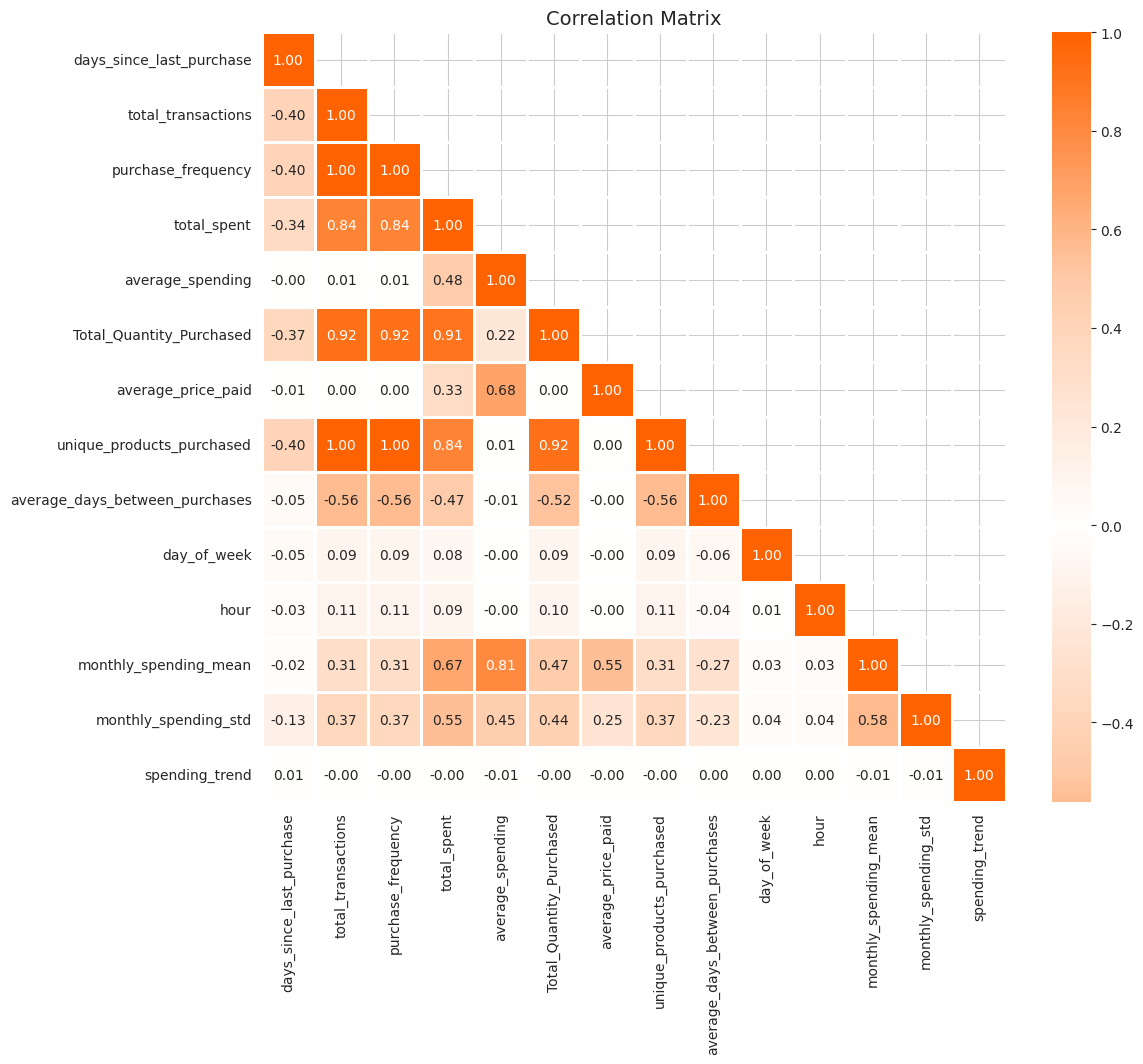

In [ ]:
#reset background style
sns.set_style('whitegrid')

#calculate the correlation matrix excluding the 'customer' column
corr = customer_data_scaled.drop(columns=['customer']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

#### Dimensionality Reduction

PCA (Principal Component Analysis): PCA is an excellent starting point because it works well in capturing linear relationships in the data, which is particularly relevant given the multicollinearity we identified in our dataset. It allows us to reduce the number of features in our dataset while still retaining a significant amount of the information, thus making our clustering analysis potentially more accurate and interpretable. Moreover, it is computationally efficient, which means it won't significantly increase the processing time.

I will apply PCA on all the available components and plot the cumulative variance explained by them. This process will allow me to visualize how much variance each additional principal component can explain, thereby helping me to pinpoint the optimal number of components to retain for the analysis:

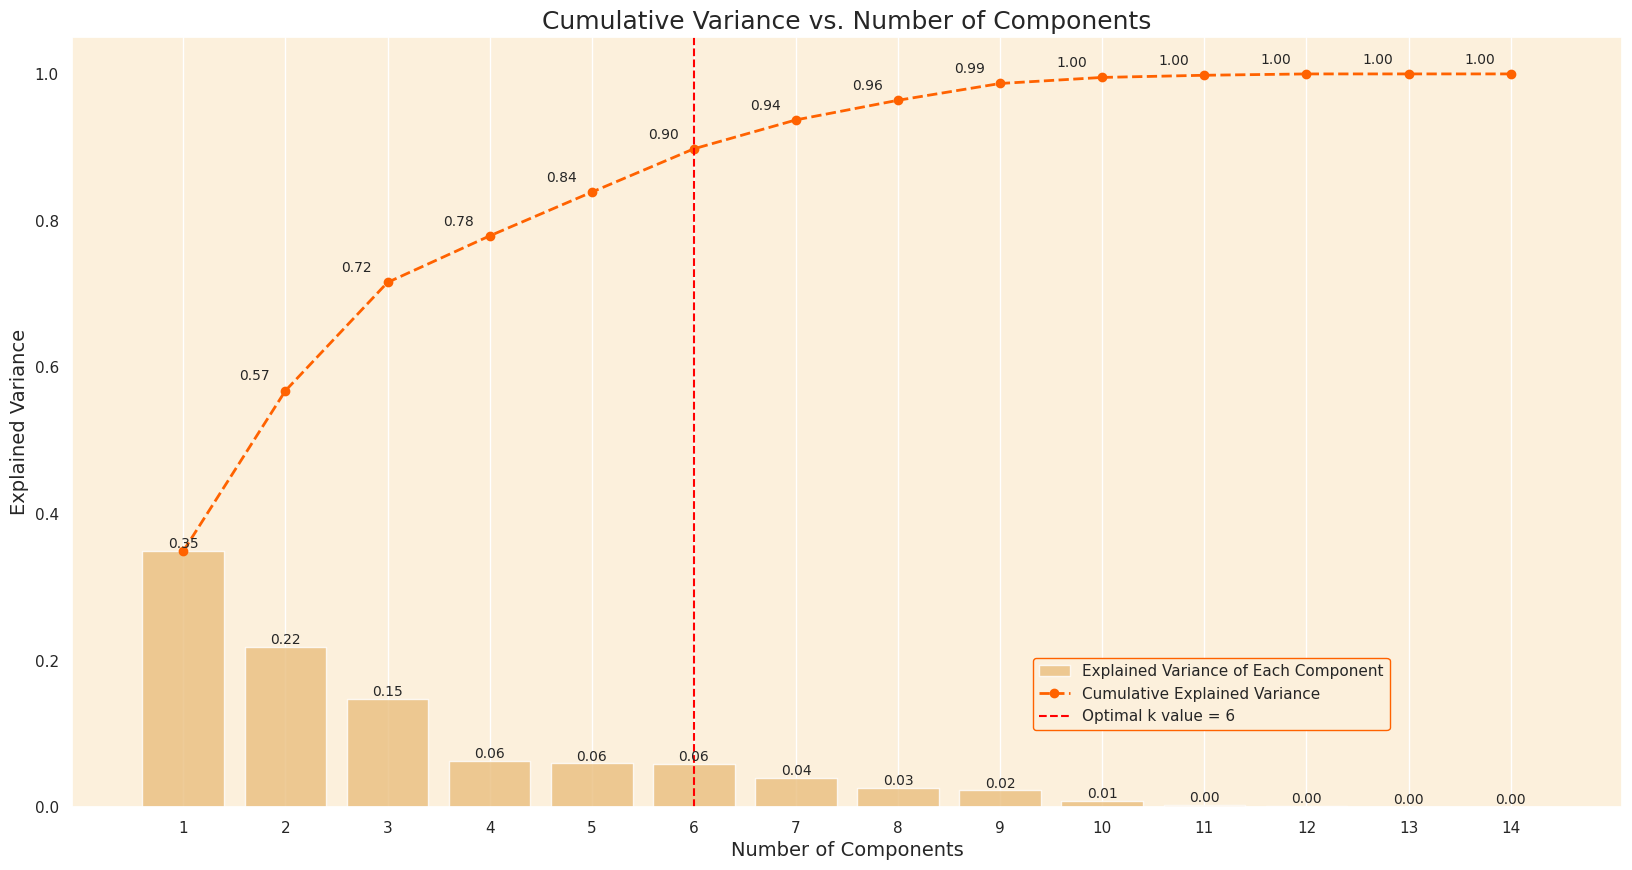

In [ ]:
#apply PCA
pca = PCA().fit(customer_data_scaled)

#calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

#set the optimal k value (based on our analysis below, we can choose 6)
optimal_k = 6

#set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

#plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

#bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

#line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

#plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

#set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

#customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

#display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

Here, we can observe that:

* The first component explains approximately 35% of the variance.

* The first two components together explain about 57% of the variance.

* The first three components explain approximately 72% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 3th component and then again after the 6th component.

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [ ]:
#creating a PCA object with 6 components
pca = PCA(n_components=6)

#fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

#creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

#adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [ ]:
customer_data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
customer                                                            
10000     0.994859 -0.321178 -0.779787  0.691396 -0.129028  1.000593
10001    -1.021736  1.095439 -0.722293  0.342180 -0.499599 -0.500063
10003     4.267590  0.066972 -1.050795 -0.796631 -0.032266  0.153603
10004    -0.533828  2.998914 -0.323406 -0.644875 -0.168768  1.303511
10005    -2.008204 -0.743035 -0.893960 -0.366379 -0.338348  1.143787

#### K-Means Clustering

K-Means is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the within-cluster sum-of-squares (WCSS), also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached.

##### Determining the Optimal Number of Clusters
* Elbow Method: It involves iterating through the data, generating clusters for various values of k. The k-means algorithm calculates the sum of squared distances between each data point and its assigned cluster centroid, known as the inertia or WCSS score. By plotting the inertia score against the k value, we create a graph that typically exhibits an elbow shape, hence the name "Elbow Method". The elbow point represents the k-value where the reduction in inertia achieved by increasing k becomes negligible, indicating the optimal stopping point for the number of clusters.
* Silhouette Method: An approach to find the optimal number of clusters in a dataset by evaluating the consistency within clusters and their separation from other clusters. It computes the silhouette coefficient for each data point, which measures how similar a point is to its own cluster compared to other clusters.

##### Elbow Method

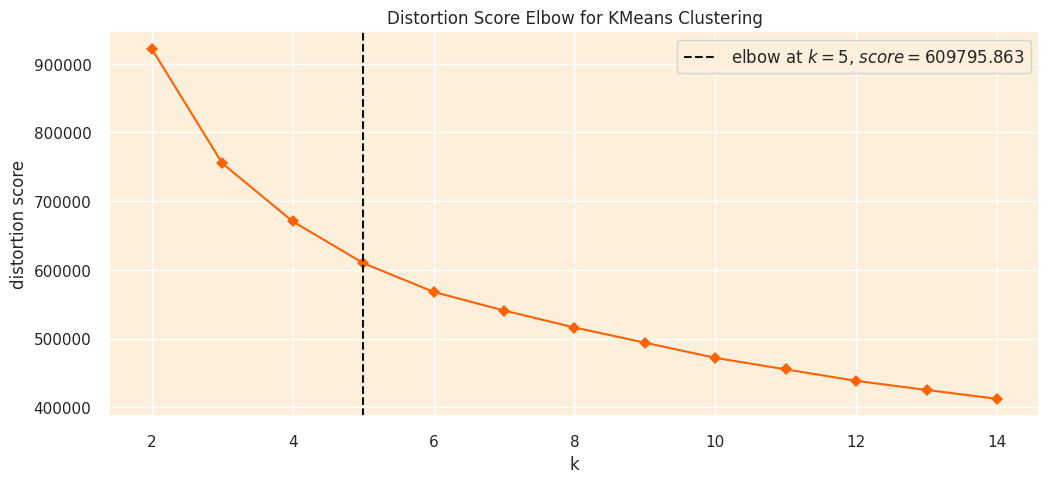

In [ ]:
#set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

#set the color palette for the plot
sns.set_palette(['#ff6200'])

#instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

#create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

#instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

#fit the data to the visualizer
visualizer.fit(customer_data_pca)

#finalize and render the figure
visualizer.show();

From the plot, we can see that the inertia continues to decrease significantly up to k=5, indicating that the optimum value of k could be between 3 and 6. To choose the best k within this range, we can employ the silhouette analysis, another cluster quality evaluation method.

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):

    plt.figure(figsize=figsize)

    #grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    #assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    #first plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    #iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    #optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    #second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        #assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        #Silhouette score text
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

KeyboardInterrupt: ignored

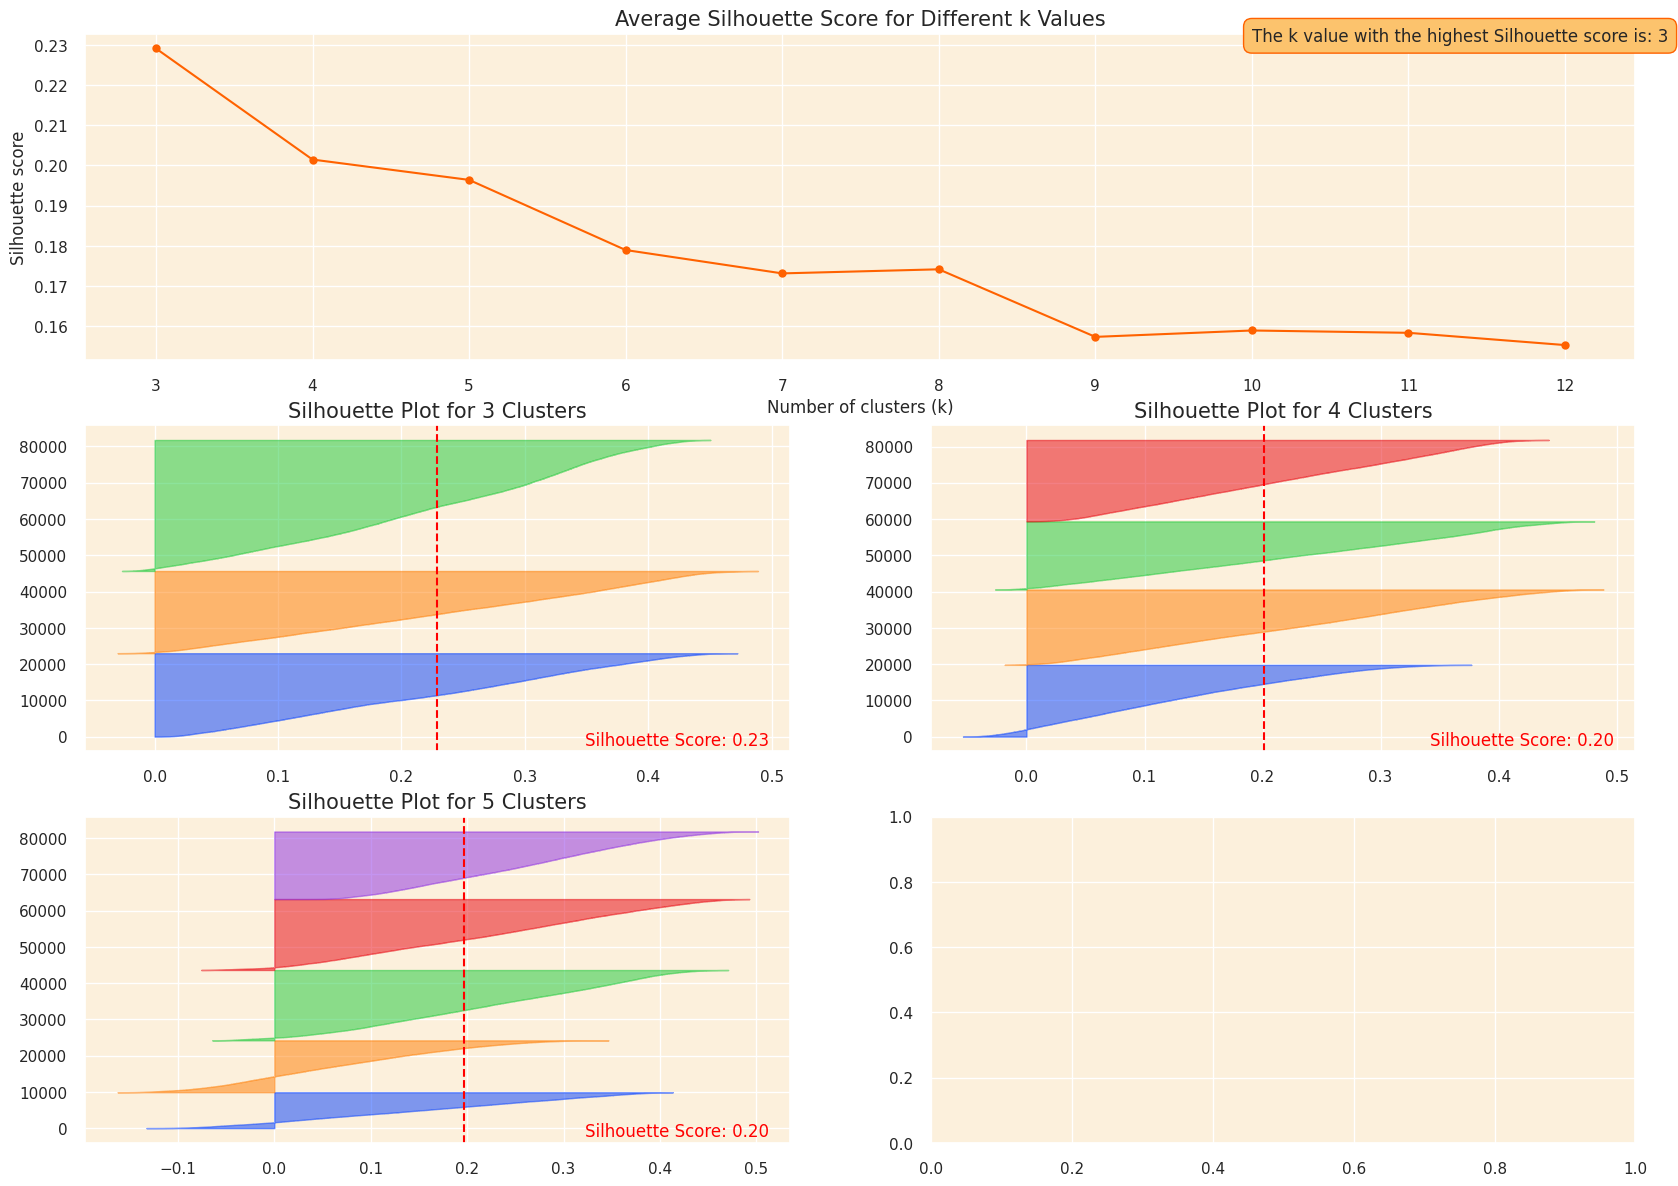

In [ ]:
silhouette_analysis(customer_data_pca, 3, 6, figsize=(20, 50))

interrupted because of computational restrictions, but we can see from the plots generated that the best choice is k=4.

### K-Means

In [ ]:
#apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

#get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

#create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}

#reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

#apply the mapping to get the new labels
new_labels = np.array([label_mapping.get(label, label) for label in kmeans.labels_])

#append the new cluster labels back to the original dataset
customer_data['cluster'] = new_labels

#append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [ ]:
customer_data.head()

customer  days_since_last_purchase  total_transactions  purchase_frequency  \
0     10000                         3                   8                   8   
1     10001                        34                   5                   5   
2     10003                        73                  13                  13   
3     10004                        83                   5                   5   
4     10005                        72                   5                   5   

   total_spent  average_spending  Total_Quantity_Purchased  \
0     10091.48       1261.435000                        36   
1      6362.12       1272.424000                        25   
2     16378.79       1259.906923                        65   
3      5562.36       1112.472000                        27   
4      3525.34        705.068000                        13   

   average_price_paid  unique_products_purchased  \
0          294.660000                          8   
1          216.532000                          5   
2          308.904615                         13   
3          269.880000                          5   
4          335.644000                          5   

   average_days_between_purchases  day_of_week  hour  monthly_spending_mean  \
0                       44.428571            2    14            1681.913333   
1                       65.000000            3     4            1272.424000   
2                       20.083333            3     9            2729.798333   
3                       43.000000            5    15            1390.590000   
4                       46.750000            1    14            1175.113333   

   monthly_spending_std  spending_trend  cluster  
0           1321.052890      -79.950286        0  
1           1043.748314      484.642000        3  
2           1148.654365       81.972857        0  
3            982.411448      125.706000        2  
4            351.952801      247.555000        3

#### Cluster Visualization

In [ ]:
#setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff', '#ffea02']
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]
cluster_3 = customer_data_pca[customer_data_pca['cluster'] == 3]

#create a 3D scatter plot
fig = go.Figure()

#add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'],
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))

#set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

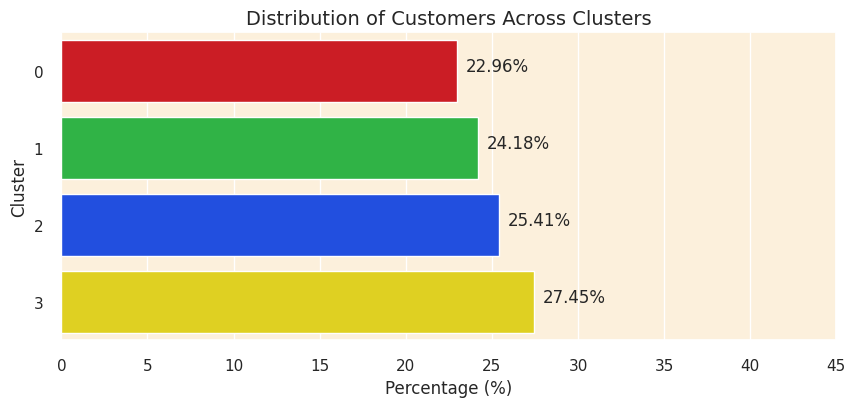

In [ ]:
#percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

#horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

#adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()

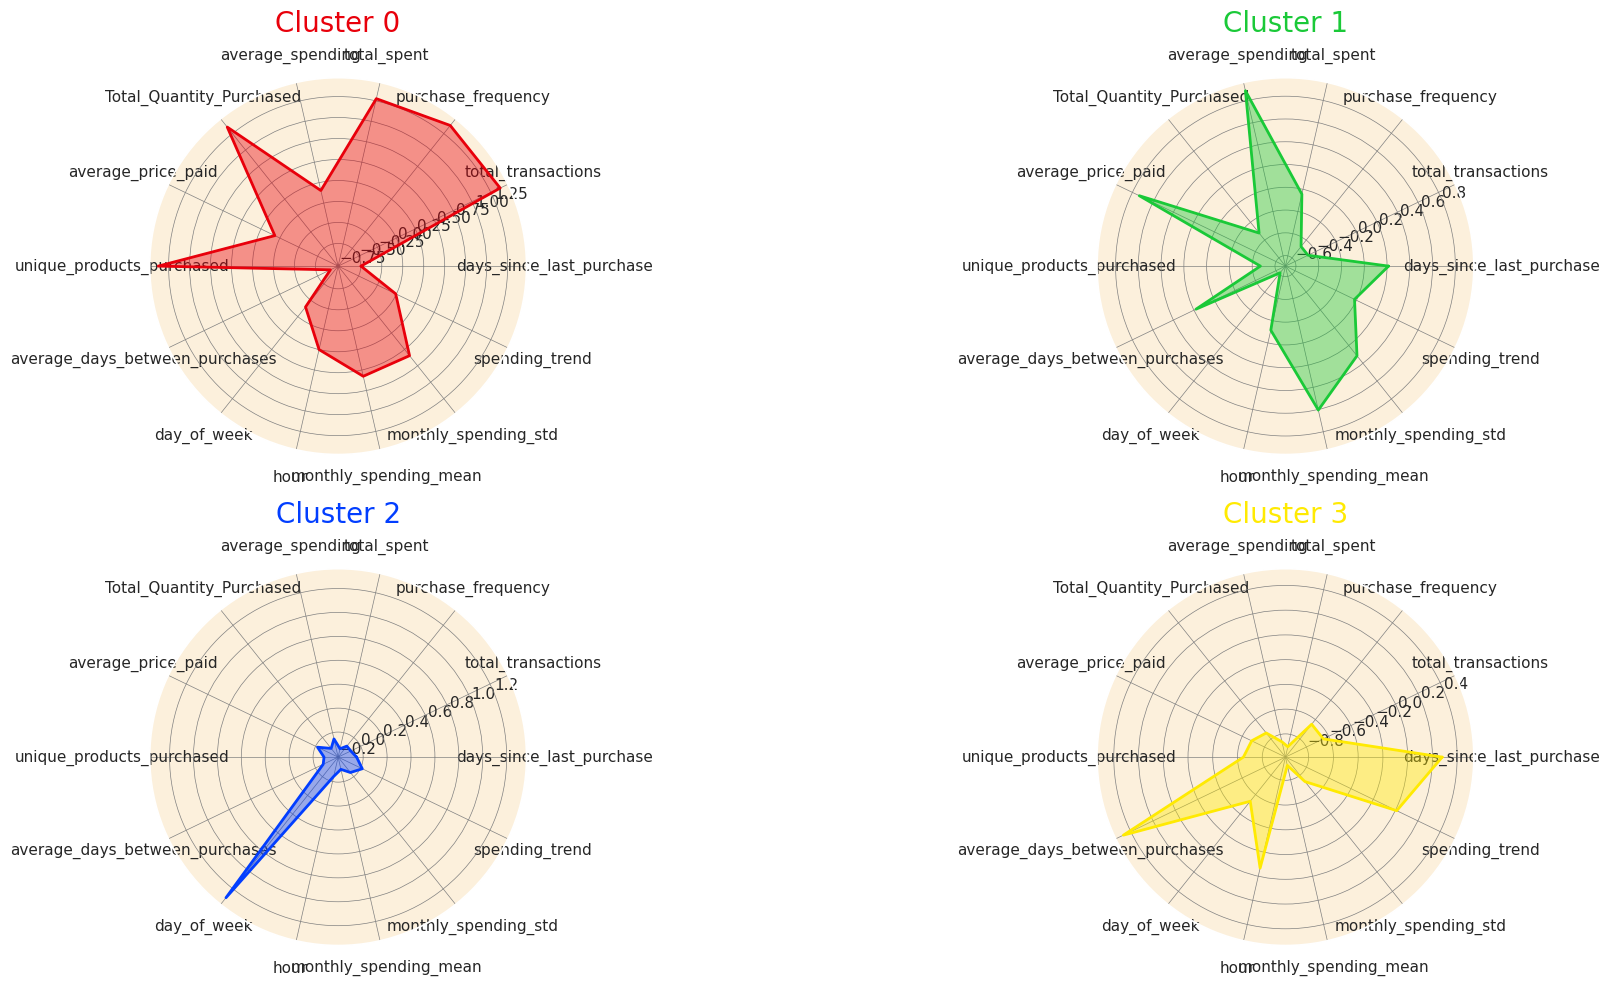

In [ ]:
#assigning the customer_data to a new dataframe
df_customer = customer_data.set_index('customer')

#standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

#create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

#clculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

#create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

#set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

#compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

#the plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

#initialize the figure with nrows=2 and ncols=2
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=2, ncols=2)

#create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop

    #calculate subplot index based on the current iteration
    row = i // 2
    col = i % 2

    create_radar_chart(ax[row, col], angles, data, color, i)

#add input data for each subplot
for r in range(2):
    for c in range(2):
        ax[r, c].set_xticks(angles[:-1])
        ax[r, c].set_xticklabels(labels[:-1])
        ax[r, c].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

Cluster 0:
- High total quantity purchased
- High frequencies and transactions
- High unique products
- Low days since last purchase
- Low average days between purchases
> Frequent High-Spenders, brand fans


Cluster 1:
- High total quantity purchased
- High average price paid
- Low purchase freq
- Low day of the week
- Low spending transactions
> High-ticket Sporadic Shoppers

Cluster 2:
- High day of week
- Low everything else
> Low-ticket Sporadic Shoppers with a Preference for Weekend Shopping

Cluster 3:
- High average days between purchases
- High spending trend
- High days since last purchase
- Low monthly spending
> Newcomers who liked the brand but are not yet loyal